In [974]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.nlp import *
from sklearn.linear_model import LogisticRegression

## create dataset

In [2]:
PATH='data/aclImdb/'
names = ['neg','pos']
names1 = ['neg', 'pos_']
names2 = ['neg_', 'pos']

In [3]:
! ls {PATH}train

labeledBow.feat pos             unsupBow.feat   urls_pos.txt
neg             unsup           urls_neg.txt    urls_unsup.txt


In [4]:
trn1,trn1_y = texts_labels_from_folders(f'{PATH}train',names1)
val1,val1_y = texts_labels_from_folders(f'{PATH}test',names1)

In [5]:
trn2,trn2_y = texts_labels_from_folders(f'{PATH}train',names2)
val2,val2_y = texts_labels_from_folders(f'{PATH}test',names2)

In [6]:
len(trn1), len(trn1_y), len(trn2), len(trn2_y)

(12500, 12500, 12500, 12500)

In [7]:
assert (trn1_y==0).all()
(trn1_y==0).all()

True

In [8]:
assert (trn1_y==0).all()
(val1_y==0).all()

True

In [9]:
assert (trn2_y==1).all()
(trn2_y==1).all()

True

In [10]:
assert (val2_y==1).all()
(val2_y==1).all()

True

In [11]:
def sample_util(data, label, n):
    assert len(data) == label.shape[0]
    idx = np.random.choice(range(len(data)),n)
    data_new = [data[i] for i in idx]
    label_new = label[idx]
    return data_new, label_new

In [12]:
def sample(data1, label1, data2, label2, n):
    t1, t2 = sample_util(data1, label1, n)
    t3, t4 = sample_util(data2, label2, n)
    data = t1 + t3
    label = np.concatenate((t2, t4))
    return data, label

In [1172]:
# trn, trn_y = sample(trn1, trn1_y, trn2, trn2_y, 64*10)
# val, val_y = sample(val1, val1_y, val2, val2_y, 64*20)

In [1173]:
trn,trn_y = texts_labels_from_folders(f'{PATH}train',names)
val,val_y = texts_labels_from_folders(f'{PATH}test',names)

## create vectors and vocab

In [1174]:
veczr = CountVectorizer(tokenizer=tokenize)

In [1175]:
trn_term_doc = veczr.fit_transform(trn)

In [1176]:
val_term_doc = veczr.transform(val)

In [1177]:
vocab = veczr.get_feature_names(); vocab[5000:5005]

['aussie', 'aussies', 'austen', 'austeniana', 'austens']

In [1178]:
vocab[:5]

['\x08\x08\x08\x08a', '\x10own', '!', '"', '#']

In [1179]:
len(vocab)

75132

In [1180]:
trn_term_doc = trn_term_doc.sign()

In [1181]:
val_term_doc = val_term_doc.sign()

## Naive Bayes

We define the **log-count ratio** $r$ for each word $f$:

$r = \log \frac{\text{ratio of feature $f$ in positive documents}}{\text{ratio of feature $f$ in negative documents}}$

where ratio of feature $f$ in positive documents is the number of times a positive document has a feature divided by the number of positive documents.

In [1182]:
def pr(y_i):
    p = x[y==y_i].sum(0)
    return p+1

In [1183]:
x=trn_term_doc
y=trn_y

p = pr(1)/pr(1).sum()
q = pr(0)/pr(0).sum()
r = np.log(p/q)
b = np.log((y==1).mean() / (y==0).mean())

In [1184]:
val_term_doc.shape

(25000, 75132)

In [1185]:
val_term_doc.shape[1]

75132

In [1186]:
x.shape

(25000, 75132)

In [1187]:
r.shape

(1, 75132)

In [1188]:
(val_term_doc @ r.T).shape

(25000, 1)

In [1189]:
val_term_doc @ r.T

matrix([[-5.25616],
        [-3.41848],
        [ 0.42768],
        ...,
        [68.81967],
        [ 4.6196 ],
        [ 3.74532]])

In [1190]:
val_y

array([0, 0, 0, ..., 1, 1, 1])

In [1191]:
pre_preds = val_term_doc @ r.T + b
preds = pre_preds.T>0
(preds==val_y).mean()

0.82844

In [1192]:
pre_preds = val_term_doc @ np.stack([np.log(p), np.log(q)]).T + b

In [1193]:
pre_preds

matrix([[ -617.48225,  -612.22609],
        [ -549.41436,  -545.99589],
        [-1036.89288, -1037.32056],
        ...,
        [-4026.31409, -4095.13376],
        [ -633.7084 ,  -638.328  ],
        [ -508.107  ,  -511.85232]])

In [1194]:
preds = pre_preds.T[0] > pre_preds.T[1]
(preds==val_y).mean()

0.82844

## Logistic regression (sklearn)

Here is how we can fit logistic regression where the features are the unigrams.

In [ ]:
LogisticRegression

In [ ]:
m = LogisticRegression(C=1e8, dual=False, max_iter=1000)
m.fit(x, y)
preds = m.predict(val_term_doc)
(preds==val_y).mean()

...and the regularized version

In [ ]:
m = LogisticRegression(C=0.1, dual=False, max_iter=1000)
m.fit(x, y)
preds = m.predict(val_term_doc)
(preds==val_y).mean()

## Logistic regression (PyTorch)

In [1195]:
from fastai.metrics import *
from fastai.model import *
from fastai.dataset import *
from fastai.nlp import *

import torch.nn as nn

In [1490]:
r.tolist()

[[0.6903518005751417,
  -0.6959425605447489,
  -0.05747923658516966,
  -0.10663050855234793,
  -0.270274745119065,
  -0.8993810407796262,
  -0.318386240553661,
  0.031690796086365845,
  -0.041576938065373326,
  -0.014319865836757546,
  -0.011538119231650138,
  -0.5348984021980792,
  0.030821230814181408,
  -0.009944205110091196,
  -0.034227440588393776,
  -0.0034373315395086167,
  -0.04613964914277314,
  -1.4978229412411597,
  -0.36825515347926874,
  -0.3485412533913457,
  -0.6959425605447489,
  -1.1014076686529133,
  -0.6959425605447489,
  0.6903518005751417,
  -1.3890897411046943,
  0.6903518005751417,
  0.6903518005751417,
  0.8726733573690963,
  0.6903518005751417,
  1.383498981135087,
  1.095816908683306,
  0.6903518005751417,
  0.6903518005751417,
  -0.0027953799848035284,
  0.5080302437811872,
  1.2011774243411326,
  -0.6959425605447489,
  0.4491897437582538,
  0.6903518005751417,
  -0.6959425605447489,
  0.2848866924669773,
  -0.29047745243658446,
  -0.6959425605447489,
  0.690

In [1868]:
class MySimpleNB(nn.Module):
    def __init__(self, nf, ny):
        super().__init__()
        self.w = nn.Embedding(nf+1, ny, padding_idx=0)
        # self.w = nn.Embedding(nf+1, ny)
        # self.w.weight.data.uniform_(-1, 1)
        # self.w.weight.data = torch.FloatTensor([0] + r.tolist()[0])
        # self.r = nn.Embedding(nf, ny)
        
    def forward(self, feat_idx):
        self.w.weight.data[0] = 0
        v = self.w(feat_idx)
        # r = self.r(feat_idx)
        # x = ((w+self.w_adj)*r/self.r_adj).sum(1)
        # x = w*r
        x = v.sum(1)
        # return F.softmax(x)
        # return x.reshape(1, -1)
        return x

In [1869]:
def binary_loss(pred, y):
    # y2 = torch.max(y,axis=1)[0]
    y2 = np.argmax(y)
    p = torch.exp(pred) / (1+torch.exp(pred))
    result = torch.mean(-(y2 * torch.log(p) + (1-y2)*torch.log(1-p)))
    # return result.reshape(1, -1)
    return result

In [1870]:
r.shape

(1, 75132)

In [1871]:
len(vocab)

75132

In [1872]:
net3 = MySimpleNB(len(vocab), 1)

In [1873]:
r.shape

(1, 75132)

In [1874]:
torch.FloatTensor([0] + r.tolist()[0])

tensor([ 0.0000,  0.6904, -0.6959,  ...,  0.6904, -0.0028, -0.6959])

In [1875]:
t

(array([64760, 65310, 66442, 66459, 66496, 66555, 66685, 66822, 67028, 67253, 67489, 68750, 69789, 72338,
        72480, 72746, 72897, 73767, 73992, 74479]),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 20,
 array([1., 0.], dtype=float32))

In [1876]:
net3.w

Embedding(75133, 1, padding_idx=0)

In [1877]:
net3.w.weight.data[0]

tensor([0.])

In [1878]:
net3.w.weight.data.shape

torch.Size([75133, 1])

In [1879]:
net3.w(torch.LongTensor([[0,1,2,3,4],[0,4,3,2,1]]))

tensor([[[ 0.0000],
         [ 0.7271],
         [ 2.1371],
         [ 0.2179],
         [-3.1283]],

        [[ 0.0000],
         [-3.1283],
         [ 0.2179],
         [ 2.1371],
         [ 0.7271]]], grad_fn=<EmbeddingBackward>)

In [1880]:
net3.w(torch.LongTensor([3]))

tensor([[0.2179]], grad_fn=<EmbeddingBackward>)

In [1881]:
embedding = nn.Embedding(10, 1)

In [1882]:
input = torch.LongTensor([[1,2,4,0],[4,3,2,9]])

In [1883]:
embedding(input)

tensor([[[-0.3781],
         [ 0.2700],
         [ 0.9056],
         [-1.0735]],

        [[ 0.9056],
         [-0.3419],
         [ 0.2700],
         [ 0.1970]]], grad_fn=<EmbeddingBackward>)

In [1884]:
embedding(input).sum(1)

tensor([[-0.2760],
        [ 1.0307]], grad_fn=<SumBackward1>)

In [1885]:
sl=val_term_doc.shape[1]
sl

75132

In [1886]:
sl=val_term_doc.shape[1]
md = TextClassifierData.from_bow(
    trn_term_doc, trn_y,
    val_term_doc, val_y,
    20,
)

In [1887]:
# ??TextClassifierData.from_bow

In [1888]:
trn_term_doc.shape

(25000, 75132)

In [1889]:
i=0

In [1890]:
net4 = MySimpleNB(len(vocab), 1)
# loss = nn.NLLLoss()
# loss = torch.nn.CrossEntropyLoss()
loss = binary_loss
lr = 1e-2
losses=[]

In [1891]:
net4.w.weight

Parameter containing:
tensor([[0.0000],
        [2.7279],
        [0.1898],
        ...,
        [0.1178],
        [0.2172],
        [0.2801]], requires_grad=True)

In [1892]:
ii=2

In [1893]:
t = md.trn_ds[ii]
ii = ii + 1
xt, _a, _b, yt = t

In [1894]:
t

(array([64760, 65310, 66442, 66459, 66496, 66555, 66685, 66822, 67028, 67253, 67489, 68750, 69789, 72338,
        72480, 72746, 72897, 73767, 73992, 74479]),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 20,
 array([1., 0.], dtype=float32))

In [1895]:
xt.shape, len(vocab)

((20,), 75132)

In [1896]:
xt.shape

(20,)

In [1897]:
xt = xt.reshape(1, 20)

In [1898]:
xt.shape

(1, 20)

In [1899]:
vocab[18178], len(vocab)

('diagnoses', 75132)

In [1900]:
_a

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [1901]:
_a.sum()

20

In [1902]:
_b

20

In [1903]:
yt

array([1., 0.], dtype=float32)

In [1904]:
md.trn_ds[ii]

(array([68543, 68900, 69092, 70464, 71058, 71297, 72507, 72699, 72897, 73049, 73113, 73176, 73489, 73512,
        73852, 73866, 73982, 74301, 74479, 74540]),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 20,
 array([1., 0.], dtype=float32))

In [1905]:
xt.shape

(1, 20)

In [1906]:
for index, idx in enumerate(to_np(xt[0])):
    if idx:
        print(vocab[idx])

surrah
t2
thatch
thea
thema
thereabouts
thismovie
throughing
tilmac
toad
topactor
turner
ungifted
wasabi
wayan
werecat
whence
workable
writter
youe


In [1907]:
vocab[0], len(vocab)

('\x08\x08\x08\x08a', 75132)

In [1908]:
net4.w(V(xt)).sum()

tensor(-6.3783, grad_fn=<SumBackward0>)

In [1909]:
xt.shape

(1, 20)

In [1910]:
y_pred = net4(V(xt))
print(y_pred)
l = binary_loss(y_pred, yt)

tensor([[-6.3783]], grad_fn=<SumBackward1>)


In [1911]:
y_pred

tensor([[-6.3783]], grad_fn=<SumBackward1>)

In [1915]:
print(net4.w.weight.grad)

tensor([[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]])


In [1913]:
l.shape

torch.Size([])

In [1914]:
l.backward()

In [1564]:
_a.shape, _a

((20,), array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]))

In [1916]:
for idx, i in enumerate(net4.w.weight.grad.data):
    for j in i:
        if j != 0:
            print(idx, j, net4.w.weight.data[idx])

64760 tensor(0.0017) tensor([-0.0951])
65310 tensor(0.0017) tensor([-2.1210])
66442 tensor(0.0017) tensor([-0.1012])
66459 tensor(0.0017) tensor([-1.5978])
66496 tensor(0.0017) tensor([-1.3434])
66555 tensor(0.0017) tensor([0.7458])
66685 tensor(0.0017) tensor([-0.0233])
66822 tensor(0.0017) tensor([-0.4625])
67028 tensor(0.0017) tensor([0.9750])
67253 tensor(0.0017) tensor([-0.3706])
67489 tensor(0.0017) tensor([-1.2145])
68750 tensor(0.0017) tensor([-0.9285])
69789 tensor(0.0017) tensor([-1.0032])
72338 tensor(0.0017) tensor([0.7364])
72480 tensor(0.0017) tensor([-0.6040])
72746 tensor(0.0017) tensor([2.3963])
72897 tensor(0.0017) tensor([-0.5142])
73767 tensor(0.0017) tensor([0.2830])
73992 tensor(0.0017) tensor([-0.0182])
74479 tensor(0.0017) tensor([-1.1172])


In [1917]:
net4.w.weight.data -= net4.w.weight.grad.data * lr

In [1918]:
lr

0.01

In [1919]:
net4.w.weight.data

tensor([[0.0000],
        [2.7279],
        [0.1898],
        ...,
        [0.1178],
        [0.2172],
        [0.2801]])

In [1920]:
net4.w.weight.grad.data

tensor([[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]])

In [1921]:
for i in net4.w.weight.grad.data:
    for j in i:
        if j != 0:
            print(j)

tensor(0.0017)
tensor(0.0017)
tensor(0.0017)
tensor(0.0017)
tensor(0.0017)
tensor(0.0017)
tensor(0.0017)
tensor(0.0017)
tensor(0.0017)
tensor(0.0017)
tensor(0.0017)
tensor(0.0017)
tensor(0.0017)
tensor(0.0017)
tensor(0.0017)
tensor(0.0017)
tensor(0.0017)
tensor(0.0017)
tensor(0.0017)
tensor(0.0017)


In [1922]:
net4.w.weight.grad.data.zero_()

tensor([[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]])

In [1923]:
from datetime import datetime

In [1924]:
len(md.trn_ds)

25000

In [1925]:
a1, a2, a3, a4 = md.trn_ds[0]

In [1926]:
a1

array([46097, 46750, 46987, 47003, 57050, 59331, 61968, 61970, 63123, 63342, 65485, 66459, 66555, 66685,
       67253, 69419, 72932, 73146, 73489, 73783])

In [1927]:
a2

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [1928]:
a3

20

In [1929]:
a4, np.argmax(a4)

(array([1., 0.], dtype=float32), 0)

In [1930]:
torch.max(V(a4))

tensor(1.)

In [1931]:
loss(net4(V(a1)), V(a4))

tensor(0.7439, grad_fn=<MeanBackward0>)

In [1932]:
net4(V(a1))

tensor([-0.9661, -0.3848, -0.3870, -1.8163, -1.9152,  0.6587, -0.6248, -0.0690,
         0.4401,  0.6355, -2.2864, -1.5978,  0.7458, -0.0233, -0.3706,  1.7371,
        -1.5658,  2.3453,  0.4581,  0.4994], grad_fn=<SumBackward1>)

In [1933]:
def score2(x, y):
    y_pred = to_np(net2(V(x)))
    return np.sum(y_pred.argmax(axis=1) == to_np(y).argmax(axis=1))/len(y_pred)

In [1934]:
def score(x, y):
    # print(f'x={x}, y={y}')
    y_pred = to_np(net2(V(x))).sum() > 0
    # print(f'y_pred={y_pred}')
    y2 = np.argmax(y)
    # print(f'y2={y2}')
    return np.sum(y_pred == y2)

In [1935]:
from tqdm import notebook

In [1936]:
datetime.now()

datetime.datetime(2020, 1, 5, 0, 0, 11, 233594)

In [ ]:
net2 = MySimpleNB(len(vocab), 1)
# loss = nn.NLLLoss()
# loss = torch.nn.CrossEntropyLoss()
loss = binary_loss
# lr = 1e-0
lr = 0.0001
train_list = []
val_list = []
loss_list = []

print(f'lr={lr}')
for epoch in range(3):
    print('')
    print('epoch:', epoch)
    print('time:', datetime.now())
    loss_list = [0]
    for index, t in tqdm(enumerate(md.trn_ds), total=len(md.trn_ds)):
        xt, _a, _b, yt = t
        y_pred = net2(V(xt))
        l = loss(y_pred, V(yt))
        # l = loss(yt, y_pred)
        loss_list.append(l)
        # print(f'{index}, {l}, {datetime.now().time()}')

        # Backward pass: 
        # compute gradient of the loss with respect to 
        # model parameters
        l.backward()
        net2.w.weight.data -= net2.w.weight.grad.data * lr
        # net2.b.data -= net2.b.grad.data * lr
        
        net2.w.weight.grad.data.zero_()
        # net2.b.grad.data.zero_()   

    if epoch % 1 == 0:
        train_scores = [loss(net2(V(x)), V(y))
                      for x, _a, _b, y in md.trn_ds]
        l2 = np.mean(to_np(train_scores))
        train_list.append(l2)

        if False:
            val_scores = [loss(net2(V(x), V(y)))
                      for x, _a, _b, y in md.val_ds]        
        val_scores = [score(x, y) for x, _a, _b, y in md.val_ds]
        l3 = np.mean(to_np(val_scores))
        val_list.append(l3)

        # print(f'epoch={epoch}, score={np.mean(val_scores)}')
        print(f'epoch={epoch}, score={l2}')
        print(f'epoch={epoch}, score={l3}')

lr=0.0001

epoch: 0
time: 2020-01-05 00:00:11.840078
100%|██████████| 25000/25000 [00:14<00:00, 1690.89it/s]
epoch=0, score=0.8060457706451416
epoch=0, score=0.52032

epoch: 1
time: 2020-01-05 00:00:37.571510
 26%|██▌       | 6376/25000 [00:03<00:11, 1691.75it/s]

In [1648]:
t = md.trn_ds[0]

In [1649]:
xt, _a, _b, yt = t

In [1659]:
t

(array([46097, 46750, 46987, 47003, 57050, 59331, 61968, 61970, 63123, 63342, 65485, 66459, 66555, 66685,
        67253, 69419, 72932, 73146, 73489, 73783]),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 20,
 array([1., 0.], dtype=float32))

In [1650]:
xt.shape, y_pred

((20,), tensor(1.3761, grad_fn=<SumBackward0>))

In [1654]:
y_pred = net2(V(xt))
y_pred

tensor(1.3761, grad_fn=<SumBackward0>)

In [1666]:
yt

array([1., 0.], dtype=float32)

In [1665]:
l = loss(y_pred, yt)
l

tensor(1.6013, grad_fn=<MeanBackward0>)

In [1663]:
l.backward()

RuntimeError: shape '[20, 20]' is invalid for input of size 20

In [1636]:
# l = loss(yt, y_pred)
loss_list.append(l)
# print(f'{index}, {l}, {datetime.now().time()}')

# Backward pass: 
# compute gradient of the loss with respect to 
# model parameters
l.backward()
net2.w.weight.data -= net2.w.weight.grad.data * lr
# net2.b.data -= net2.b.grad.data * lr

net2.w.weight.grad.data.zero_()
# net2.b.grad.data.zero_()   

RuntimeError: shape '[20, 20]' is invalid for input of size 20

In [1633]:
net2.w(V(xt)).sum(1)

IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

In [1612]:
net2(V(xt))

IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

In [1611]:
net2.w(V(xt))

tensor([-0.6425, -0.0039, -0.0378,  0.0137,  0.0021,  0.2349,  0.1294, -0.5241,
         0.7996,  0.2971,  0.0267, -0.0053, -0.1981, -0.0426, -0.0225,  0.0592,
        -0.0718,  1.0470,  0.0216,  0.2935], grad_fn=<EmbeddingBackward>)

In [1479]:
import matplotlib.pyplot as plt
import pandas as pd

In [1480]:
df = pd.DataFrame({'train':train_list, 'valid':val_list})

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a457d9c18>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x1a457eea90>], dtype=object)

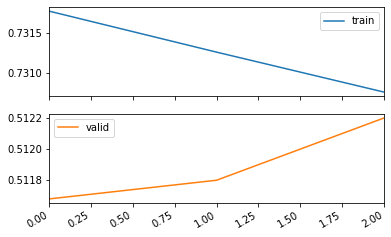

In [1481]:
df.plot(subplots=True)

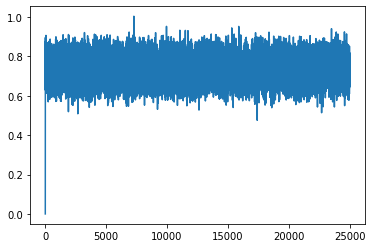

In [1482]:
plt.plot(loss_list)

In [114]:
# net2.r

In [66]:
net2.w

Embedding(19973, 2, padding_idx=0)

In [67]:
val_dl = iter(md.val_dl)
val_scores = [score(_b, y) for x, _a, _b, y in val_dl]

In [68]:
np.mean(val_scores)

0.484765625

In [69]:
val_scores

[0.421875,
 0.4375,
 0.546875,
 0.484375,
 0.4375,
 0.53125,
 0.5,
 0.40625,
 0.375,
 0.515625,
 0.515625,
 0.546875,
 0.46875,
 0.4375,
 0.5625,
 0.4375,
 0.5,
 0.46875,
 0.359375,
 0.4375,
 0.484375,
 0.5,
 0.46875,
 0.515625,
 0.53125,
 0.40625,
 0.5,
 0.609375,
 0.53125,
 0.59375,
 0.453125,
 0.5,
 0.390625,
 0.453125,
 0.546875,
 0.5,
 0.453125,
 0.515625,
 0.5,
 0.546875]

In [70]:
val_dl = iter(md.val_dl)

In [71]:
x, _a, _b, y = next(val_dl)

In [72]:
score(x, y)

/Users/shaojun/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until


0.0

In [73]:
w = net2.w(x)

In [75]:
# r = net2.r(x)

In [76]:
x = ((w+net2.w_adj)*r/net2.r_adj).sum(1)

TypeError: mul(): argument 'other' (position 1) must be Tensor, not matrix

In [ ]:
x

In [ ]:
result = F.softmax(x)
result

In [ ]:
result.shape

In [ ]:
to_np(result).argmax(axis=1) == to_np(y).argmax(axis=1)

In [ ]:
to_np(y)

## Deep NB